# Optimisation strategies

STAD computes the network in which the distances between its nodes correlate maximally with the original distance matrix. To find this network, pySTAD provides several exploration strategies. This notebook demonstrates these strategies.

Finding the optimal network is a 1 dimensional problem: below what distance should an edge be created between two nodes? However, the problem can be interpreted in two ways: in terms of edge distances or in terms of the number of edges. The [R implementation](https://github.com/vda-lab/stad) and paper ([Alcaide & Aerts (2020)](https://ieeexplore.ieee.org/document/9096616/)) took the latter approach, in which all edges were sorted by their distance and the $n$ edges with the lowest distances were added to the network. In addition, they used Simulated Annealing (SA) to find the optimal network. SA is a optimisation algorithm that, when properly configured, converges to the global minimum of a function. SA was used with the goal of making STAD a parameter-free function. It should reliably find the optimal STAD network without manual intervention. However, SA itself has quite complex parameters (f.i. the temperature schedule) that can influence its behaviour quite strongly. Therefore, this implementation of STAD also provides several other exploration strategies, making it easy to find approximations of the optimal network with lower computational costs.

In [1]:
import stad as sd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from scipy.spatial.distance import pdist

## The Data

In this notebook, we use the barcelona dataset. Each node is a day and the distance between nodes was computed based on traffic measurements (see [Alcaide & Aerts (2020)](https://ieeexplore.ieee.org/document/9096616/) for details). 

In [2]:
def rgb_to_hsv(rgb):
    r = float(rgb[0])
    g = float(rgb[1])
    b = float(rgb[2])
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = high, high, high

    d = high - low
    s = 0 if high == 0 else d/high

    if high == low:
        h = 0.0
    else:
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return list(int(hex[i:i+int(hlen/3)], 16) for i in range(0, hlen, int(hlen/3)))

def hex_to_hsv(hex):
    return rgb_to_hsv(hex_to_rgb(hex))


dist = np.array(pd.read_csv('./data/barcelona_distance_matrix.csv', header=None))
vertex_data = pd.read_csv('./data/dates.csv', header=0)
vertex_data['hue'] = vertex_data['colour'].map(lambda x: hex_to_hsv(x)[0])
vertex_data = vertex_data.drop(['id', 'colour'], axis = 1)
vertex_data.head()

date_day  day       hue
0  2017-10-01    7  0.486799
1  2017-10-02    1  0.120915
2  2017-10-03    2  0.117347
3  2017-10-06    5  0.090717
4  2017-10-07    6  0.474026

## Exploration sweeps

Instead of Simulated Annealing, we start by discussing the 1-dimensional parameter-sweeps that pySTAD provides. The `StadExploration` enumeration lists all available exploration strategies. Namely, linear and logarithmic sweeps in terms of the (normalised) edge distance or number of added edges. For all sweeps the user can specify the start point, end point, and number of steps. When the number of steps is set to 1, the start point will be used. So, when you already know how many edges should be added, you can avoid unnecessary computation.

#### Linear in edge distance

The easiest sweep is linear in terms of distances. The starting and ending value are interpreted as normalised distance. This sweep may not provide the best performance, because it evaluates relatively many points towards the upper end of the sweep-range. Generaly, the peak in correlation is quite early, especially when a penalty is used.

In [8]:
%%timeit 
sd.stad(dist, sweep=sd.SweepDistanceLinear(), edge_penalty=0.1)

337 ms ± 7.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


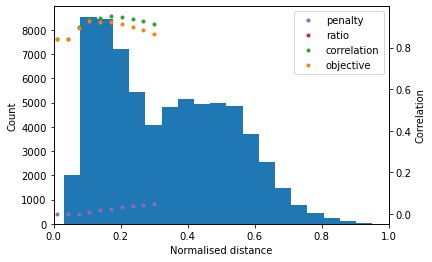

In [7]:
(network, sweep) = sd.stad(dist, sweep=sd.SweepDistanceLinear(), edge_penalty=0.1)
sd.plot.sweep(dist, sweep)
plt.show()

#### Logarithmic in edge distance

The logarithmic sweep in terms of edge distances is similar. The use of the logarithmic function decreases the computational load, as it evaluates less graphs with many edges. However, if the minimum value is too low, the sweep will evaluate quite a few points that are too low. On the other hand, the cost of these evaluations are low because they include only a few number of edges.

In [10]:
%%timeit 
sd.stad(dist, sweep=sd.SweepDistanceLogarithmic(), edge_penalty=0.1)

317 ms ± 8.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


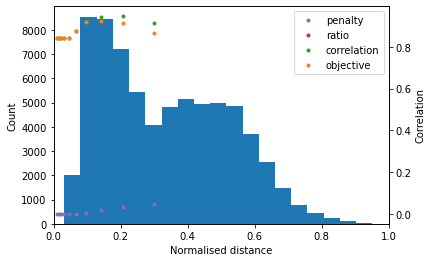

In [9]:
(network, sweep) = sd.stad(dist, sweep=sd.SweepDistanceLogarithmic(), edge_penalty=0.1)
sd.plot.sweep(dist, sweep)
plt.show()

#### Linear in number of edges

One can also sweep in terms of the number of edges. Note, the starting and ending value of the sweep are now interpreted as a factor on the maximum number of edges (note the range of evaluated points). Using the number of edges tends to avoid evaluating the smallest graphs.

In [11]:
%%timeit 
sd.stad(dist, sweep=sd.SweepEdgesLinear(), edge_penalty=0.1)

336 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


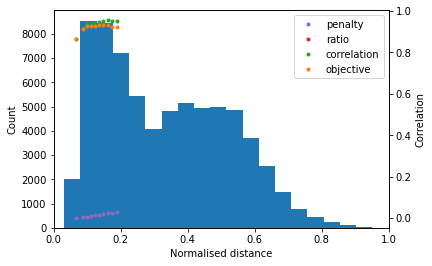

In [12]:
(network, sweep) = sd.stad(dist, sweep=sd.SweepEdgesLinear(), edge_penalty=0.1)
sd.plot.sweep(dist, sweep)
plt.show()

#### Logarithmic in number of edges

This is strategy avoids evaluating both the smallest and largest graphs and finds a good network in few iterations.

In [13]:
%%timeit 
sd.stad(dist, sweep=sd.SweepEdgesLogarithmic(), edge_penalty=0.1)

324 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


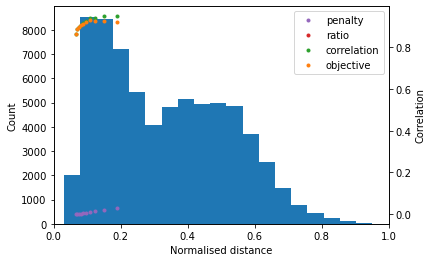

In [14]:
(network, sweep) = sd.stad(dist, sweep=sd.SweepEdgesLogarithmic(), edge_penalty=0.1)
sd.plot.sweep(dist, sweep)
plt.show()

## Simulated Annealing (and other optimisers)

The `OptimizerFunction` class can be used to run simulated annealing or other (scipy) optimization functions. By default, this class uses SciPy's dual annealing.

0:00:02.137453


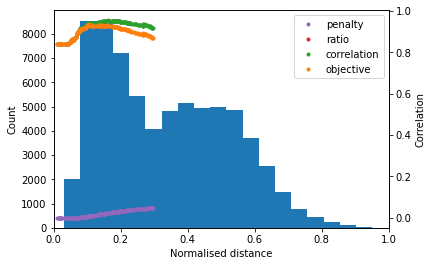

In [6]:
from timeit import default_timer as timer
import datetime

start = timer()
sweep = sweep=sd.OptimizerFunction(initial_temp=100, no_local_search=True)
(network, sweep) = sd.stad(dist, sweep=sweep, edge_penalty=0.1)
end = timer()
print(datetime.timedelta(seconds=end-start))

sd.plot.sweep(dist, sweep)
plt.show()

Normally, it is very important to verify that SA converged. However, STAD will always use the best visited network, not the last. So, even if SA did not converge, the resulting network may be good.

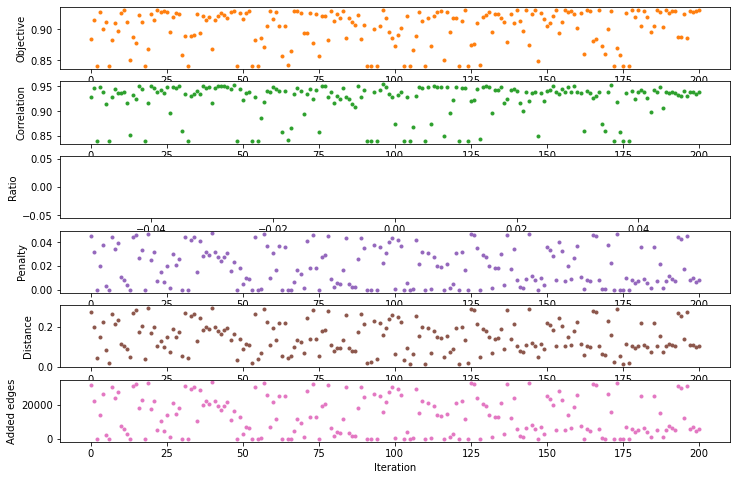

In [7]:
fig = sd.plot.traces(sweep)
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

The output of the optimization function is also available to work with

In [8]:
sweep.optimiser_output

     fun: -0.9317871268133768
 message: ['Maximum number of iteration reached']
    nfev: 201
    nhev: 0
     nit: 100
    njev: 0
  status: 0
 success: True
       x: array([0.10596749])

#### Other optimisers

It is also possible to define custom optimisers. These should take the following form:

In [10]:
from scipy.optimize import shgo

def custom_optimiser(fun, args, bounds, maxiter, **kwargs):
    return shgo(lambda x: fun(x[0], *args), bounds, options={
            'maxiter': maxiter,
            **kwargs
        }
    )

Note, that the `fun` argument performs all the bookkeeping, so the custom optimiser does not have to return anything.

0:00:01.762629


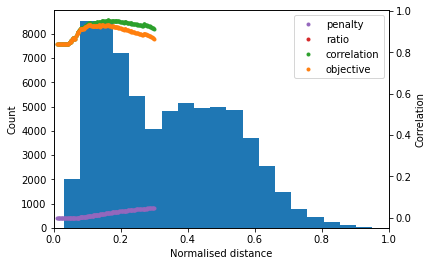

In [12]:
start = timer()
sweep = sd.OptimizerFunction(function=custom_optimiser, n=4, n_steps=8)
(network, sweep) = sd.stad(dist, sweep=sweep, edge_penalty=0.1)
end = timer()
print(datetime.timedelta(seconds=end-start))

sd.plot.sweep(dist, sweep)
plt.show()

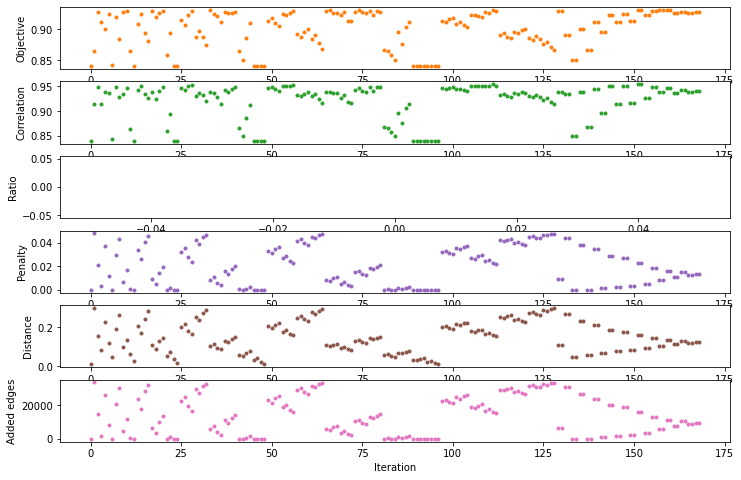

In [13]:
fig = sd.plot.traces(sweep)
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

In [14]:
sweep.optimiser_output

     fun: -0.9315903976471344
    funl: array([-0.9315904 , -0.93131005, -0.93046808, -0.93028256, -0.92962204,
       -0.92862414, -0.92775237, -0.92640115, -0.92639054, -0.92424133,
       -0.92261216, -0.9224997 , -0.91363261, -0.91227976, -0.91131803,
       -0.90033281, -0.89565829, -0.89016612, -0.86718747, -0.85054633])
 message: 'Optimization terminated successfully.'
    nfev: 169
     nit: 8
   nlfev: 40
   nlhev: 0
   nljev: 20
 success: True
       x: array([0.10515625])
      xl: array([[0.10515625],
       [0.16179688],
       [0.13460938],
       [0.1096875 ],
       [0.14367188],
       [0.13007812],
       [0.12554688],
       [0.12101562],
       [0.11648437],
       [0.17765625],
       [0.18671875],
       [0.09382812],
       [0.08476562],
       [0.08023437],
       [0.21164062],
       [0.23203125],
       [0.07117187],
       [0.26828125],
       [0.05757813],
       [0.04851562]])